[Go to last cell](#bottom_cell)
<a id='top_cell'></a>

In [1]:
##### Code toggle #####
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is hidden by default for easier reading.
Toggle <a href="javascript:code_toggle()">here</a>.''')

In [2]:
##### Imports #####
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mpcol
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
#plt.style.available                 # uncomment for Matplotlib stylesheet list

In [4]:
##### Aesthetics #####
sns.set(style='whitegrid')

palettes = {}
palettes['gender'] = {'W':'#c5c2f4', 'M':'#e57068'}
palettes['country'] = sns.color_palette('Set2').as_hex()

In [5]:
df = pd.read_csv('BostonMar2014.csv')

# Initial look at the data, cleanup, then feature engineering

In [6]:
# Overview: some columns that should obviously be numeric are objects, probably strings embedded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [7]:
# Reset column display width, get a different overview
pd.set_option('display.max_columns', 50)
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [8]:
# These are the timepoints along the route, some have dirty data
checkpoints = ['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k']
for point in checkpoints:
    df = df.loc[df[point] != '-']
    df[point] = df[point].astype(float)

In [9]:
# This column was already clean, now tack it on
checkpoints.append('official')

### There are some final times less than 2 hours, which is impossible.  The world record is something like 2 hours 4 minutes.  I don't know where the anomaly comes from, but the dataset is substantial enough to drop them.

In [10]:
impossible_times = df.loc[df['official'] <= 120].shape[0]
print('Dropping ' + str(impossible_times) + ' sub 2-hour finishing times.')
df = df.loc[df['official'] >= 120]

Dropping 43 sub 2-hour finishing times.


### *"ctz"* stands for citizenship, and only shows up when it's differs from *"country"*.  I'm dropping it and sticking with just country.  The Boston Marathon uses 5-year ranges to group people in, so I'll do the same.  *"division"* is less clear, and is mostly broken up by age and sex, but might include wheelchair and sight-impaired divisions.  Without breaking people into their age groups, there are over 6000 divisions.....

In [11]:
# Ages range from 18 to 81, so we'll have 10 brackets just as they do officially
ages = {'18-39':(18,39),
        '40-44':(40,44),
        '45-49':(45,49),
        '50-54':(50,54),
        '55-59':(55,59),
        '60-64':(60,64),
        '65-69':(65,69),
        '70-74':(70,74),
        '75-79':(75,79),
        '80+':(80,84)}

# Compare age with age range (the value), and return correct bracket (the key)
def bracket_age(age):
    for key in ages:
        if (ages[key][0] <= age <= ages[key][1]):
            return key

# Create a new column, drop 'citizenship' and 'state' columns, and create a palette
df['age_bracket'] = df['age'].apply(lambda x: bracket_age(x))
df.drop(columns=['ctz', 'state'], inplace=True)
palettes['age'] = sns.cubehelix_palette(len(ages), start=0, rot=-0.75, light=0.8, dark=0.3)

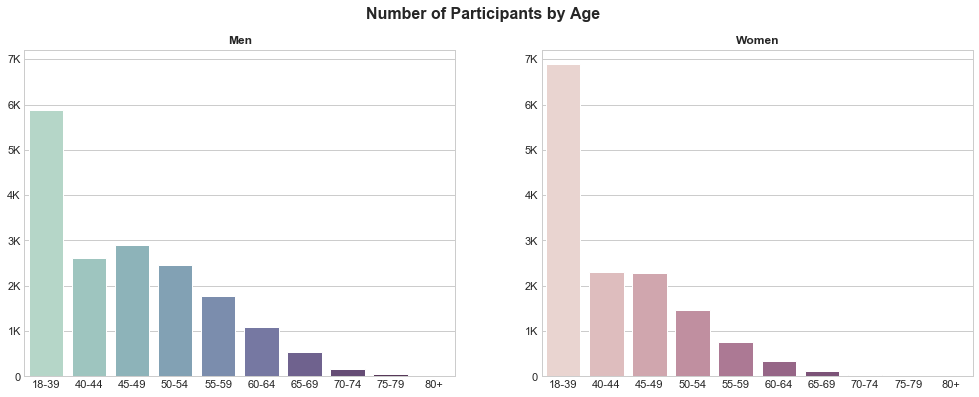

In [12]:
# formatting function to represent numbers in the thousands as '4K' or similar
def thousands(y, pos):
    if y >= 1000:
        return '{:1.0f}K'.format(y*1e-3)
    else:
        return 0

# This customizes the tick labels, using function above
formatter = FuncFormatter(thousands)

plt.style.use('seaborn-whitegrid')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17,6))
fig.suptitle('Number of Participants by Age', fontweight='bold', fontsize=16)

men = df[df['gender'] == 'M']['age_bracket']
women = df[df['gender'] == 'F']['age_bracket']
frames = [men, women]
labels = ['Men', 'Women']

# Create a palette for each
palettes['men'] = sns.cubehelix_palette(len(ages), start=1, rot=-0.75, light=0.8, dark=0.2)
palettes['women'] = sns.cubehelix_palette(len(ages))

# Create two countplots separated by sex
for idx, ax in enumerate([ax0, ax1]):   
    sns.countplot(frames[idx], ax=ax,
                  order=ages.keys(),
                  label=labels[idx],
                  palette=palettes[labels[idx].lower()])
    ax.set(ylim=(0,7200), ylabel='', xlabel='')
    ax.set_title(labels[idx], fontweight='bold')
    ax.yaxis.set_major_formatter(formatter)

# The object-oriented way to do plt.show()
fig.canvas.draw_idle()

In [13]:
print('Participants in the 2014 Boston Marathon')
print('Women: ' + str(women.count()) + '\nMen:   ' + str(men.count()))

Participants in the 2014 Boston Marathon
Women: 14157
Men:   17449


### Have a look at times through the race by age bracket

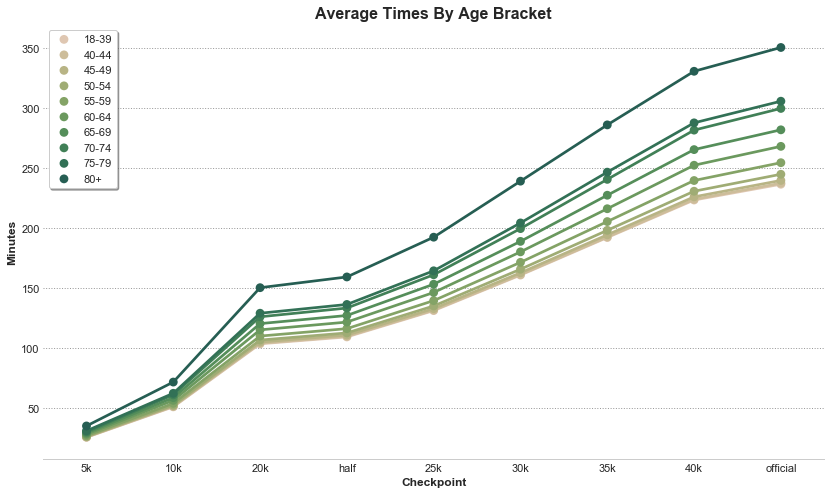

In [14]:
# Tidy up for easier vis
stacked = pd.melt(df, value_vars=checkpoints, var_name='checkpoint', value_name='time', id_vars=['age_bracket'])

# Checkpoint completion time by wave
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14,8))
ax = sns.pointplot(data=stacked,
            x='checkpoint',
            y='time',
            hue='age_bracket',
            hue_order=list(ages.keys()),
            palette=palettes['age'],
            ci=None,
            orient="v")

ax.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
sns.despine(left=True)

plt.title('Average Times By Age Bracket', fontweight='bold', fontsize=16)
plt.ylabel('Minutes', fontweight='bold')
plt.xlabel('Checkpoint', fontweight='bold')
plt.legend(shadow=True, fancybox=True, frameon=True)
plt.show()

### Runners wear a bib, which identifies which wave they start in and dictates their start time.  What's not obvious without searching is the Elite division, which contains only numbers 1 - 100.
> Bib numbers are color coded. Red bibs (numbers 101 - 8,999) are assigned to Wave 1 (10:00 a.m.). White bibs (numbers 9,000 to 17,999) are assigned to Wave 2 (10:25 a.m.). Blue bibs (numbers 18,000 to 26,999) are assigned to Wave 3 (11:00 a.m.) Yellow bibs (numbers 27,000+) are assigned to Wave 4 (11:25 a.m.) [Boston Marathon Waves](http://registration.baa.org/2014/cf/Public/iframe_EntryLists.cfm)

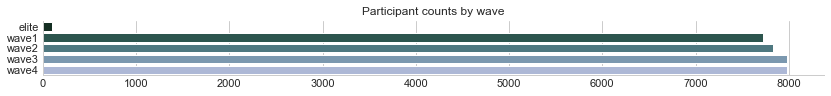

In [15]:
# Define waves
wave_defs = {'elite':(0,100),
             'wave1':(101,8999),
             'wave2':(9000,17999),
             'wave3':(18000,26999),
             'wave4':(27000, 40000)}

palettes['wave'] = sns.cubehelix_palette(6, start=2, reverse=True)

# Define a function to convert bibs to waves
def convert_bib(x):    
    try:
        for key in wave_defs:
            if wave_defs[key][0] <= float(x) <= wave_defs[key][1]: return key             
    except ValueError:   
        if 'W' in str(x): return 'elite'
        elif 'F' in str(x): return 'elite'    
    else: 
        print(float(x))
        return np.nan

# Create a wave column
df['wave'] = df['bib'].apply(lambda x: convert_bib(x))

# Plot the figure
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14,1))
ax = sns.countplot(y=df['wave'], palette=palettes['wave'])
sns.despine()
ax.set(xlabel='', ylabel='')
plt.title('Participant counts by wave')
plt.show()

In [16]:
# Which countries participate?
countries = df['country'].unique()
print('Total participating countries: ', len(countries))
print(countries, '\n')

# How many participants per country?
print('Participants per country (top 12):')
print(df['country'].value_counts()[:12])

# Break out countries with < 200 runners
others = df['country'].value_counts().index.tolist()[5:]
df['country_oth'] = df['country'].apply(lambda x: np.where(x in others, 'OTH', x))

Total participating countries:  77
['KEN' 'ETH' 'USA' 'RUS' 'BLR' 'MAR' 'RSA' 'CAN' 'JPN' 'UKR' 'BRA' 'ITA'
 'GER' 'AUS' 'SWE' 'GRE' 'FRA' 'GBR' 'ESP' 'SLO' 'IRL' 'KOR' 'ARG' 'COL'
 'POL' 'CHN' 'NED' 'ISR' 'CZE' 'SUI' 'NOR' 'CRC' 'MEX' 'GUA' 'SIN' 'DEN'
 'HUN' 'BEL' 'FIN' 'AUT' 'CHI' 'ISL' 'VEN' 'DOM' 'PER' 'HKG' 'SVK' 'NZL'
 'TPE' 'PHI' 'CAY' 'POR' 'UAE' 'IND' 'PAN' 'ROU' 'LUX' 'ESA' 'TRI' 'MAS'
 'VGB' 'EGY' 'BRN' 'EST' 'ECU' 'LIE' 'TUR' 'BOL' 'BAR' 'URU' 'QAT' 'INA'
 'BER' 'TAN' 'BAH' 'CRO' 'ZIM'] 

Participants per country (top 12):
USA    26919
CAN     2160
GBR      340
ITA      209
MEX      202
GER      180
JPN      168
AUS      123
IRL      116
FRA      112
BRA       86
ESP       83
Name: country, dtype: int64


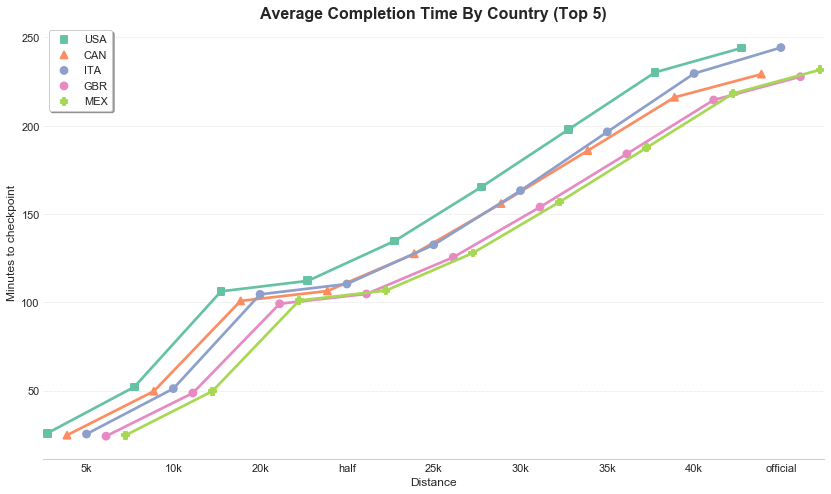

In [17]:
top_countries = df.dropna()

# Tidy completion times for easier visualization
stacked = pd.melt(top_countries, value_vars=checkpoints, var_name='checkpoint',
                  value_name='time', id_vars=['country_oth'])

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(14,8))
ax1 = sns.pointplot(data=stacked,
                   x='checkpoint',
                   y='time',
                   hue='country_oth',
                   hue_order=['USA', 'CAN', 'ITA', 'GBR', 'MEX'],
                   palette=palettes['country'],
                   markers=[',', '^', 'o', 'o', 'P'],
                   ci=None,
                   orient="v",
                   dodge=0.9,
                   label='Country')

ax1.grid(color='grey', linestyle=':', linewidth=0.5, axis='y', alpha=0.5)
ax1.legend(shadow=True, fancybox=True, frameon=True)
ax1.set(xlabel='Distance', ylabel='Minutes to checkpoint')
ax1.set_title('Average Completion Time By Country (Top 5)', fontsize=16, fontweight='bold')
sns.despine(left=True)

fig.canvas.draw_idle()

### Here is a look at split times, or how fast a runner completes their first vs. second half.  Very few are able to run an even or negative split.  A negative split means running the second half faster than the first.

<Figure size 1152x576 with 0 Axes>

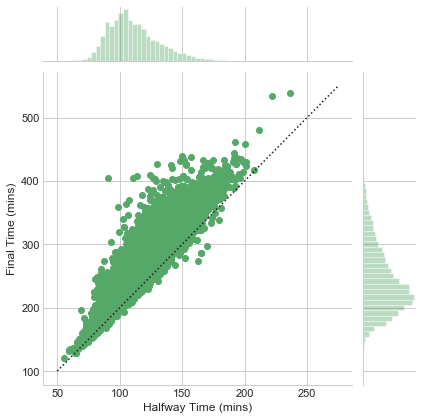

In [18]:
plt.figure(figsize=(16, 8))

with sns.axes_style('whitegrid'):
    g = sns.jointplot('half', 'official', df, kind='scatter', color='g')
    g.ax_joint.plot(np.linspace(50, 275), np.linspace(100, 550), ':k')
    g.set_axis_labels('Halfway Time (mins)', 'Final Time (mins)')

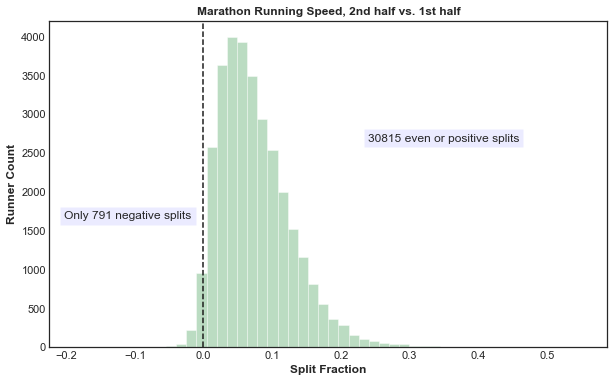

In [19]:
# Let's see the degree to which someone splits the race: create a new column
df['split_frac'] = 1 - 2*df['half'] / df['official']

# calculate negative / positive split counts and messages
negs = df[df['split_frac'] < 0]['split_frac'].count()
neg_message = 'Only ' + str(negs) + ' negative splits'
pos_message = str(df['split_frac'].shape[0] - negs) + ' even or positive splits'

# plot, and draw a zero / even split line
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(df['split_frac'], kde=False, color='C2')
plt.axvline(0, color='k', linestyle='--', lw=1.5)

# text boxes with messages, other labels
plt.text(-0.11, 1650, neg_message, ha='center', bbox=dict(facecolor='blue', alpha=0.08))
plt.text(0.35, 2650, pos_message, ha='center', bbox=dict(facecolor='blue', alpha=0.08))
plt.xlabel('Split Fraction', fontweight='bold')
plt.ylabel('Runner Count', fontweight='bold')
plt.title('Marathon Running Speed, 2nd half vs. 1st half', fontweight='bold')

plt.show()

### Let's look at splits just by sex

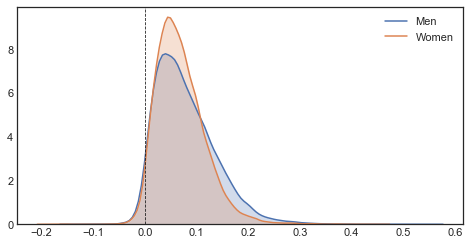

In [20]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(df[df['gender'] == 'M']['split_frac'], label = 'Men', shade=True)
sns.kdeplot(df[df['gender'] == 'F']['split_frac'], label = 'Women', shade=True)
plt.axvline(0, color='k', linestyle='--', lw=0.8)

plt.show()

### How do they break down by both age and sex?
Note: there's only 1 woman in this dataset who is 80+, which is why the plot displays as it does.

The spread of values is more broad generally in men, and more even comparing the sexes when in the middle categories.  It's interesting to look at the 18-39 category, and compare it with the 75-79... they seem to have the highest percentage of even or negative splits.

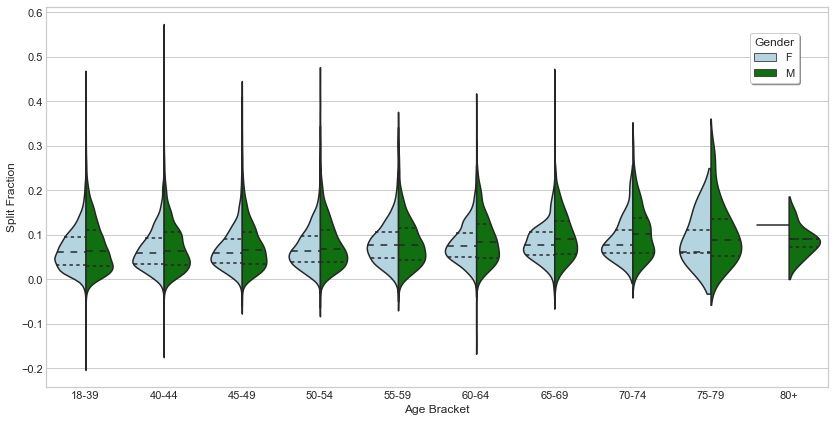

In [21]:
plt.figure(figsize=(14,7))
with sns.axes_style(style='whitegrid'):
    g = sns.violinplot('age_bracket', 'split_frac', hue='gender', data=df,
                    split=True, inner='quartile', palette=['lightblue', 'green'],
                    order=ages.keys())
    
    g.set(ylabel='Split Fraction', xlabel='Age Bracket')
    g.legend(title='Gender', shadow=True, fancybox=True, frameon=True, loc=(0.9, 0.8))

### Here's a look at the correlation of split time and finishing time, broken down by country (top 5 by participation) and sex.  The correlation is strong.  I plotted split times on the y-axis, as it was more intuitive that way.

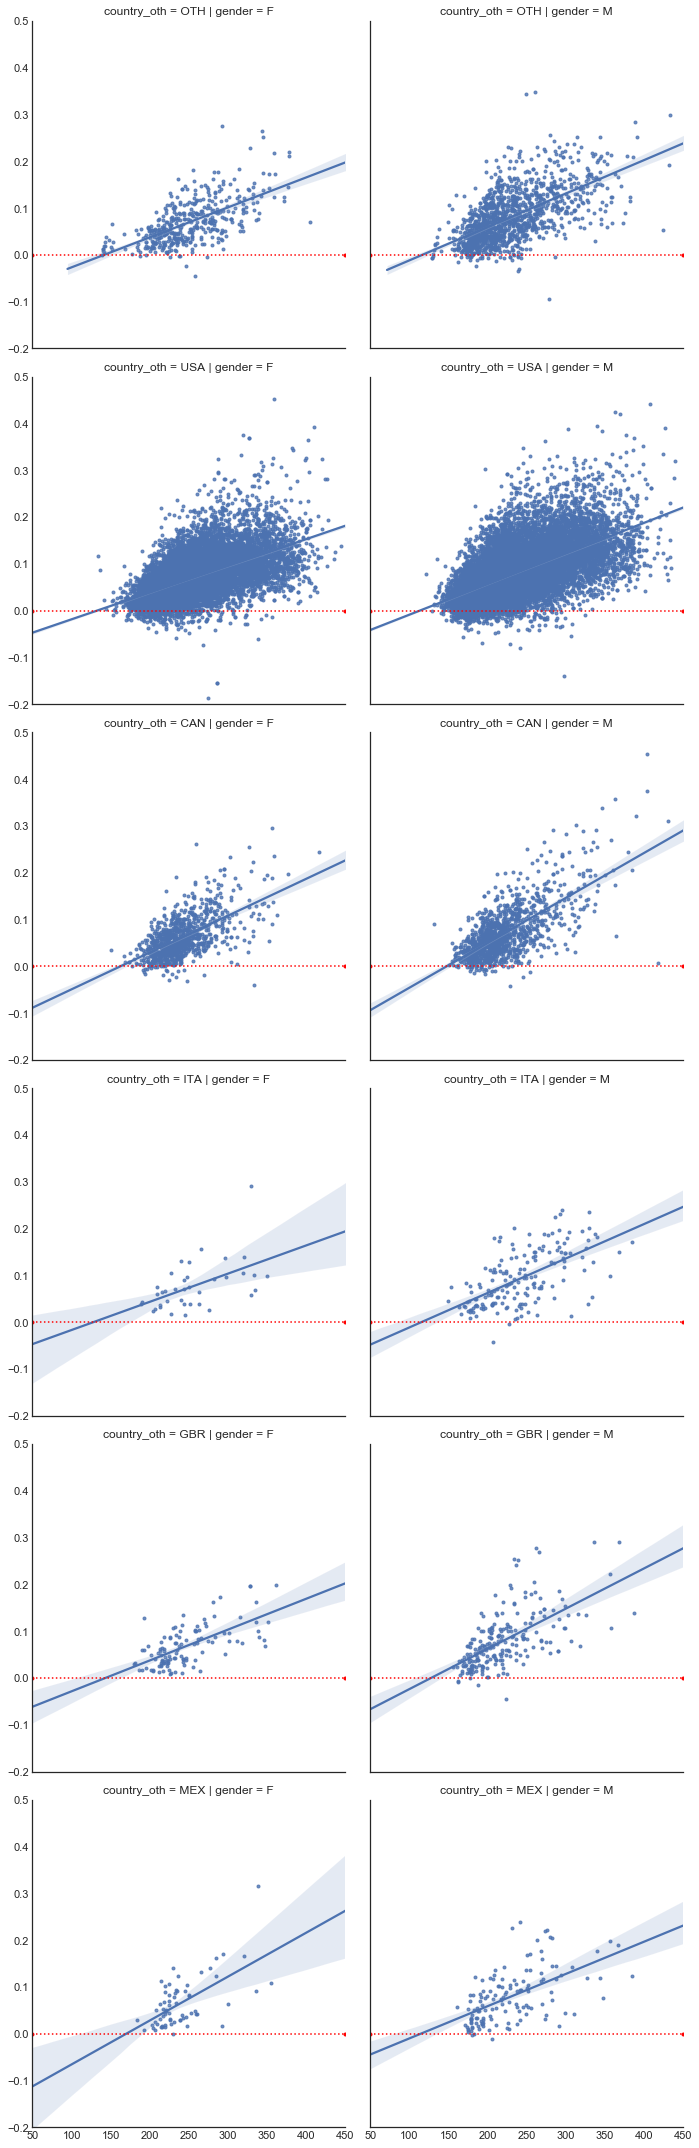

In [22]:
plt.style.use('seaborn-white')
g = sns.lmplot('official', 'split_frac', col='gender', row='country_oth', data=df, markers='.')
g.map(plt.axhline, y=0, color='red', ls=':')
g.set(xlim=(50, 450), ylim=(-0.2, 0.5))

plt.show()

In [23]:
features = pd.DataFrame()
features['age'] = df['age']
features['half'] = df['half']
features['official'] = df['official']
features['pace'] = df['pace']
features['division'] = df['division']
features['overall'] = df['overall']
features['male'] = np.where(df['gender'] == 'M', 1, 0)

# Generate/populate columns for countries
for country in ['USA', 'CAN', 'ITA', 'GBR', 'MEX', 'OTH']:
    features[country] = np.where(df['country_oth'] == country, 1, 0)
    
# Same for the 5 waves
for wave in df['wave'].unique():
    features[wave] = np.where(df['wave'] == wave, 1, 0)

In [25]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from matplotlib.gridspec import GridSpec

In [26]:
X = features[features.columns[:6]]

# Normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_norm = pd.DataFrame(np_scaled, columns=list(X))
X_norm['male'] = np.where(features['male'] == 1, 1, 0)

for country in ['USA', 'CAN', 'ITA', 'GBR', 'MEX', 'OTH']:
    X_norm[country] = np.where(df['country_oth'] == country, 1, 0)

for wave in df['wave'].unique():
    X_norm[wave] = np.where(df['wave'] == wave, 1, 0)    

#X_norm.head()

In [27]:
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=300, n_jobs=1)

In [28]:
y_pred_k = KMeans(n_clusters=5, random_state=42).fit_predict(X_norm)
y_pred_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit_predict(X_norm)

features['k_clusters'] = y_pred_k + 1
df['k_clusters'] = y_pred_k + 1
features['ms_clusters'] = y_pred_ms + 1

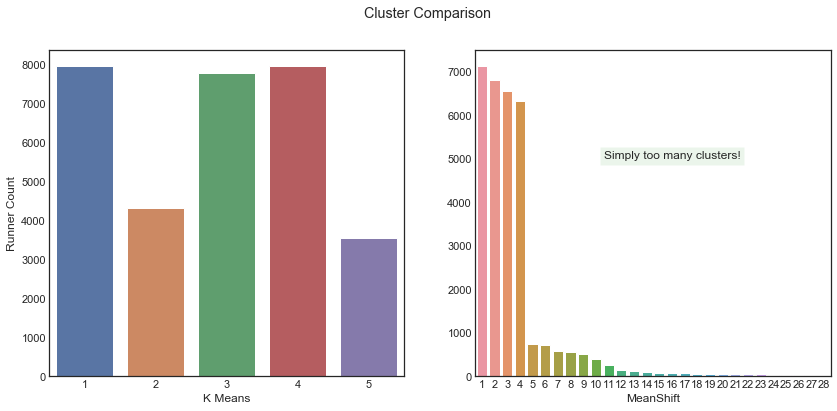

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1 = sns.countplot(features['k_clusters'], ax=ax1)
ax2 = sns.countplot(features['ms_clusters'], ax=ax2)
ax1.set(xlabel='K Means', ylabel='Runner Count')
ax2.set(xlabel='MeanShift', ylabel='')
ax2.text(15, 5000, 'Simply too many clusters!', ha='center', bbox=dict(facecolor='green', alpha=0.08))

fig.suptitle('Cluster Comparison')
plt.show()

In [30]:
palettes['clust_rgb'] = sns.color_palette('Set2', 5).as_hex()
palettes['clust_cmap'] = mpcol.ListedColormap(palettes['clust_rgb'], name='my_name')
sns.set()

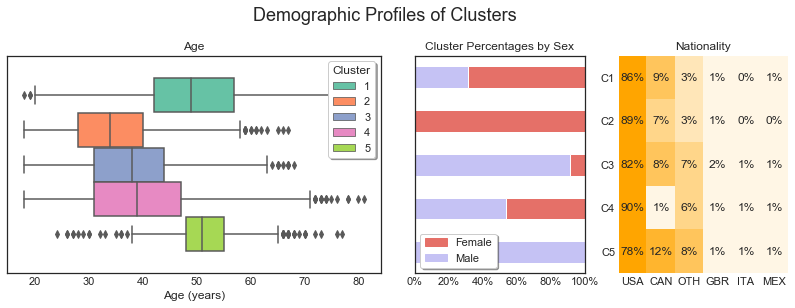

In [31]:
plt.style.use('seaborn-white')

# Making the grid one size larger, so the first graph can be stretched out
fig = plt.figure(figsize=(14,4))
gs = GridSpec(1, 4)

features['y'] = 1 # Add a dummy column for plotting in-place

##### By Age #####
ax1 = plt.subplot(gs[0, 0:2])    
ax1 = sns.boxplot(y='y',
            x='age',
            data=features,
            hue='k_clusters',
            palette=sns.color_palette(palettes['clust_rgb']),
            orient='h',
            saturation=1)

ax1.axes.get_yaxis().set_visible(False)
ax1.set_title('Age')
ax1.set_xlabel('Age (years)')
ax1.legend(loc="upper right", title='Cluster', shadow=True, fancybox=True, frameon=True)

##### Breakdown by Sex #####
ax2 = plt.subplot(gs[0, 2:3])
for cluster in np.arange(6):
    f_percent = features[features['k_clusters'] == cluster]['male'].mean()
    m_percent = 1 - features[features['k_clusters'] == cluster]['male'].mean()
    f_std = features[features['k_clusters'] == cluster]['male'].std()
    m_std = 1 - features[features['k_clusters'] == cluster]['male'].std()    
    
    p1 = plt.barh(cluster, f_percent, 0.5, color='#c5c2f4')
    p2 = plt.barh(cluster, m_percent, 0.5, left=f_percent, color='#e57068')

ax2.invert_yaxis()
ax2.set_xticklabels(['{}%'.format(tick) for tick in np.arange(0,120,20)])
ax2.set_yticklabels([''])

gender_legend = [mpatches.Patch(color='#e57068', label='Female'),
                 mpatches.Patch(color='#c5c2f4', label='Male')]

ax2.legend(handles=gender_legend, loc="lower left", shadow=True, fancybox=True, frameon=True)
ax2.set_title('Cluster Percentages by Sex')

##### By country #####
countries = df['country_oth'].value_counts().index.tolist()
country_data = {}

# Note the list comprehension embedded in the loop, and the division to calculate a percentage
# This is very hard to read, but difficult to do differently
for cluster in range(1,6):
    country_data[cluster] = [features[(features['k_clusters'] == cluster) 
                                      & (features[country] == 1)][country].count()
                                      / features[features['k_clusters'] == cluster].shape[0]
                                        for country in countries]
    
ax3 = plt.subplot(gs[0, 3:4])
ax3 = sns.heatmap(pd.DataFrame(country_data, index=countries).transpose(), 
                  annot=True,
                  fmt=".0%",
                  cmap=sns.light_palette("orange"),
                  cbar=False,
                  vmin=0,
                  vmax=0.15)

plt.yticks(rotation=0)
cluster_labels = ['C{}'.format(x) for x in range(1,6)]
ax3.set_yticklabels(cluster_labels)
ax3.set_title('Nationality')

plt.suptitle('Demographic Profiles of Clusters',fontsize=18, y=1.05)
plt.show()

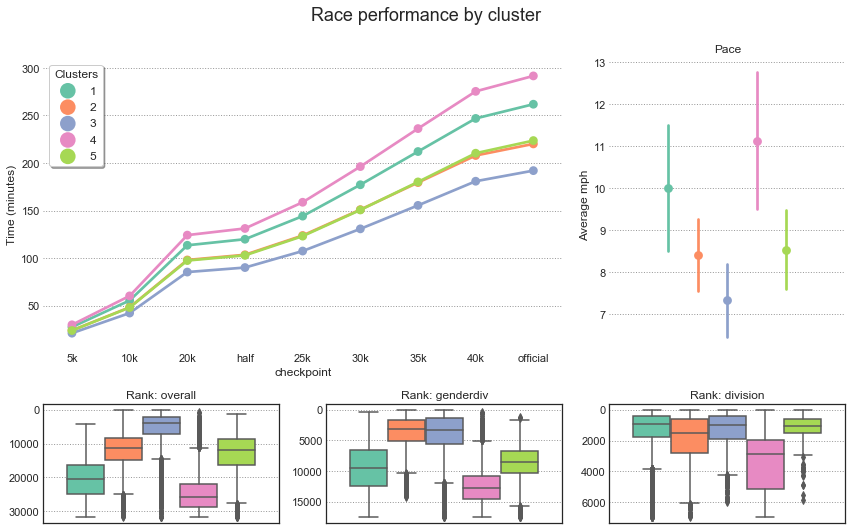

In [38]:
# Plot a figure summarizing race performance across clusters
gs = GridSpec(3, 3)
plt.figure(figsize=(12,7))

# Tidy the data for easier visualization.
stacked_checkpoints = pd.melt(df,
                              value_vars=['5k', '10k', '20k', 'half', '25k', '30k', '35k', '40k', 'official'],
                              var_name='checkpoint',
                              value_name='time',
                              id_vars=['k_clusters'])

# Visualize checkpoint completion time by wave
ax1 = plt.subplot(gs[0:2, 0:2])    
sns.pointplot(data=stacked_checkpoints,
              x='checkpoint',
              y='time',
              hue='k_clusters',
              palette=sns.color_palette(palettes['clust_rgb']),
              ci=95,
              orient="v")

sns.despine(left=True)
ax1.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
ax1.set_ylabel('Time (minutes)')
ax1.legend(title='Clusters', markerscale=2, fontsize=12, shadow=True, fancybox=True, frameon=True)
 
##### Pace #####
df['y'] = features['y'] # Add a dummy column for plotting in-place.
ax2 = plt.subplot(gs[0:2, 2]) # Place the plot on the grid
sns.pointplot(x='y',
              y='pace',
              hue='k_clusters',
              data=df,
              ci='sd',
              palette=sns.color_palette(palettes['clust_rgb']),
              dodge=0.5)

ax2.legend_.remove()
ax2.set_xticklabels('')
ax2.axes.get_xaxis().set_visible(False)

sns.despine(left=True, bottom=True) # Aesthetics
ax2.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)

ax2.set_ylabel('Average mph')
ax2.set_title('Pace')


##### Rankings #####
stacked_divisions = pd.melt(df,
                            value_vars=['overall', 'division', 'genderdiv'],
                            var_name='division',
                            value_name='rank',
                            id_vars=['k_clusters'])
stacked_divisions['y'] = 1 # Add a dummy column for plotting in-place.

# Iterate through the division rankings and plot them
for idx, division in enumerate(['overall', 'genderdiv', 'division']):
    ax3 = plt.subplot(gs[2, idx:idx+1])    

    sns.boxplot(x='y',
                y='rank',
                data=stacked_divisions[stacked_divisions['division'] == division],
                hue='k_clusters',
                palette=sns.color_palette(palettes['clust_rgb']),
                orient='v',
                saturation=1)
    
    ax3.legend_.remove()
    ax3.set_xticklabels('')
    ax3.axes.get_xaxis().set_visible(False)
    ax3.set_ylabel('')
    
    ax3.grid(color='grey', linestyle=':', linewidth=1, axis='y', alpha=0.8)
    ax3.invert_yaxis() # Invert the plot so that higher ranks appear near the top.
    ax3.set_title('Rank: {}'.format(division))    

# Name and show the overall plot.
plt.suptitle('Race performance by cluster',fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

[Back to top](#top_cell)
<a id='bottom_cell'></a>